In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

## First load a few images to identify ROIs and check threshold

In [32]:
pgroup='p21185'
runnumber = 25
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
print (jsonfile)
run_name = jsonfile.split('/')[-3]
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
if scan.parameters['scan_name'] != 'dummy':
    if scan.parameters['units'] == ['fs']:
        Timezero_mm = get_timezero_NBS(jsonfile)
        scanvar = scan.readbacks - mm2fs(Timezero_mm, 0)
    else: 
        scanvar = scan.readbacks
    print ('Scan contains {} step(s), scanvar goes from {:.2f} to {:.2f} {}'.format(len(scan), scanvar[0], scanvar[-1], scan.parameters['units'][0]))
else:
    print ('No motors moved')

run: 0025
/sf/alvra/data/p21185/raw/run0025-FeMn_Zscan_7400eVpink/meta/scan.json
Scan contains 41 step(s), scanvar goes from 1.80 to 2.80 mm


In [33]:
threshold_low = 5
threshold_high = 15

Timezero_mm = 100.02694

channels_list = []

reducedir='../Claudio/Reduced_XES_timescans/'
saveflag = True
#####################################################

import sfdata.sfdatafile
sfdata.sfdatafile.ju = None
scan = SFScanInfo(jsonfile)

try:
    Timezero_mm = get_timezero_NBS(jsonfile)
    flag = True
except:        
    Timezero_mm = Timezero_mm
    flag = False
    
spectra_on, spectra_off,_,_, ROIs, Delay_fs, Delay_mm, meta = XES_delayscan_ROIs(scan, channels_list, threshold_low, threshold_high)

print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

if scan.parameters['units'] == ['nS']:
    Delay_fs = scan.values
#    Delay_fs = Delay_fs - 0.17
else:
    Delay_fs = scan.values
    Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)
    
if saveflag:
    os.makedirs(reducedir+run_name, exist_ok=True)
    save_data_XES_timescans_ROIs(reducedir, run_name, spectra_on, spectra_off, ROIs, Delay_mm, Delay_fs, meta)    

Processing: run0025-FeMn_Zscan_7400eVpink
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

JF02T09V03:ROI_KaDW     501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaDW_bkg 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaUP     501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KaUP_bkg 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbDW     501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbDW_bkg 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbUP     501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_KbUP_bkg 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL4:EvtSet 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 9 / 9 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 248 pump and 248 unpump shots
------------------------------
Timezero 

In [35]:
Delay_fs = scan.readbacks

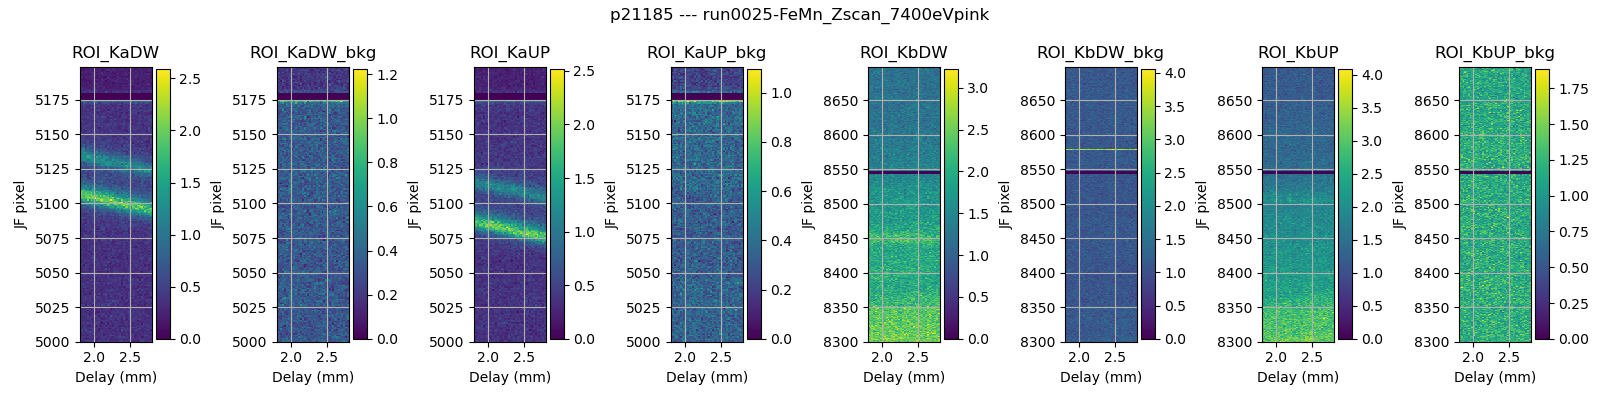

In [36]:
energy_calib = False

m = -5.430862659608205
b = 16537.553363439678

bin_ = 1

vmin = None
vmax = None

################################################

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs), figsize=(16,4))
plt.suptitle(titlestring)
for i, (key, ax) in enumerate(zip(ROIs, axs.flatten())):
    matrix_off = []
    for index_step in range(len(spectra_off)):
        matrix_off.append(spectra_off[index_step][key])#.split(':')[-1]])
        
    yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    y_axis_rebin, matrix_off_rebin = plot_tool_static_2D(matrix_off, 0, yaxis, bin_)
    
    ylabel = 'JF pixel'
    if energy_calib:
        y_axis_rebin = (y_axis_rebin-b)/m
        ylabel = 'Emission energy (eV)'
        
    plt.sca(ax)
    plt.title(key.split(':')[-1])
    plt.pcolormesh(Delay_fs, y_axis_rebin, np.transpose(np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
    #plt.plot(Delay_fs, np.transpose(np.asarray(matrix_off_rebin)).sum(axis=0))
    plt.colorbar()
    plt.ylabel(ylabel)
    #plt.ylim(3120, 3180)
    plt.grid()
    plt.xlabel('Delay ({})'.format(scan.parameters['units'][0]))
plt.tight_layout()

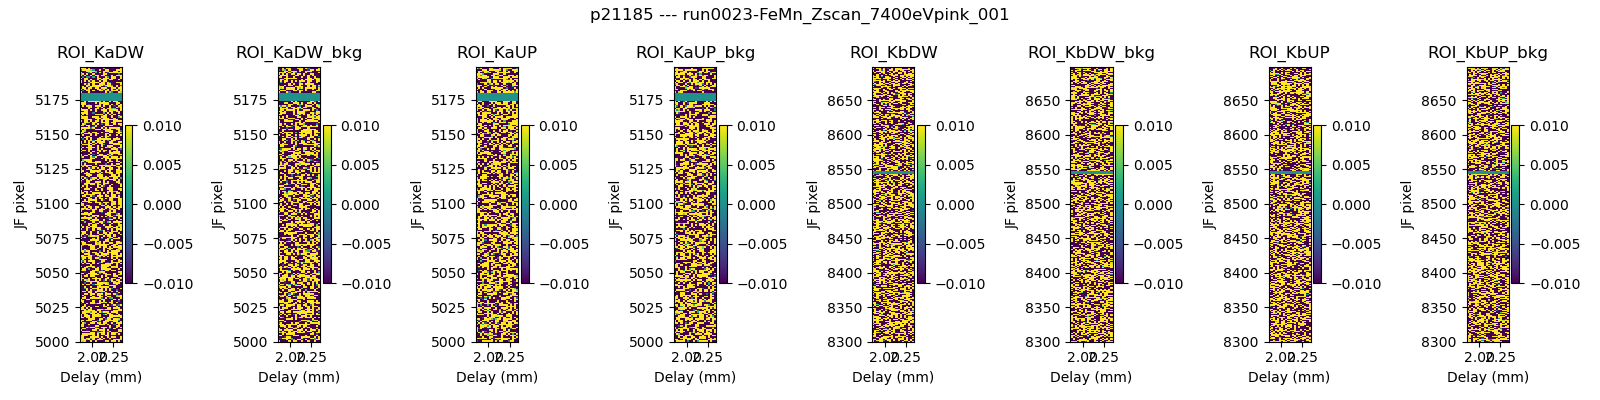

In [20]:
energy_calib = False

m = -5.430862659608205
b = 16537.553363439678

bin_ = 1

vmin = -0.01
vmax = 0.01

################################################

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs), figsize=(16,4))
plt.suptitle(titlestring)
for i, (key, ax) in enumerate(zip(ROIs, axs.flatten())):
    matrix_on = []
    matrix_off = []
    for index_step in range(len(spectra_on)):
        matrix_on.append(spectra_on[index_step][key])#.split(':')[-1]])
        matrix_off.append(spectra_off[index_step][key])#.split(':')[-1]])
        
    yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    y_axis_rebin, matrix_on_rebin, matrix_off_rebin = plot_tool_2D(matrix_on, matrix_off, 0, yaxis, bin_)
    
    ylabel = 'JF pixel'
    if energy_calib:
        y_axis_rebin = (y_axis_rebin-b)/m
        ylabel = 'Emission energy (eV)'
    
    plt.sca(ax)
    plt.title(key.split(':')[-1])
    plt.pcolormesh(Delay_fs, y_axis_rebin, np.transpose(np.asarray(matrix_on_rebin) - np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.ylabel(ylabel)
    #plt.ylim(3120, 3180)
    plt.xlabel('Delay ({})'.format(scan.parameters['units'][0]))
plt.tight_layout()

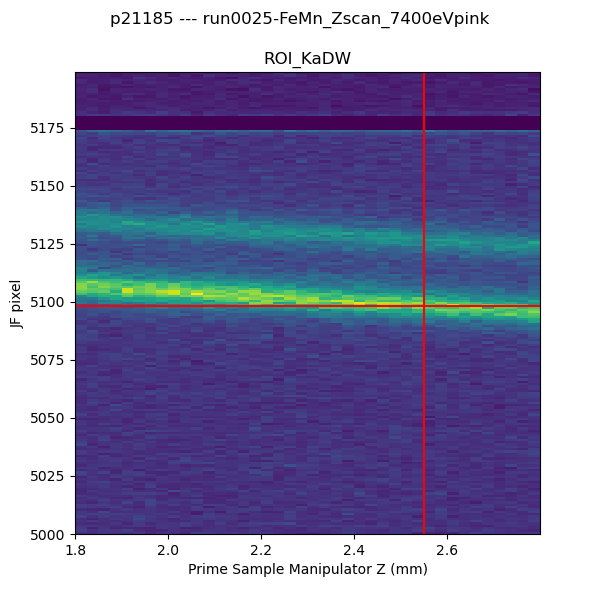

In [44]:
key = 'JF02T09V03:ROI_KaDW'

bin_ = 1

vmin = None
vmax = None

##########################################################

plt.figure(figsize=(6,6))
plt.suptitle(titlestring)
matrix_on = []
matrix_off = []
for index_step in range(len(spectra_on)):
    matrix_on.append(spectra_on[index_step][key])#.split(':')[-1]])
    matrix_off.append(spectra_off[index_step][key])#.split(':')[-1]])

yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
y_axis_rebin, matrix_on_rebin, matrix_off_rebin = plot_tool_2D(matrix_on, matrix_off, 0, yaxis, bin_)

plt.title(key.split(':')[-1])
#plt.plot(Delay_fs, (np.transpose(np.asarray(matrix_on_rebin) - np.asarray(matrix_off_rebin))[31]))



plt.pcolormesh(Delay_fs, y_axis_rebin, np.transpose(np.asarray(matrix_on_rebin) + np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
#plt.pcolormesh(Delay_fs, y_axis_rebin, np.transpose(np.asarray(matrix_on_rebin)), vmin = vmin, vmax = vmax)
#plt.colorbar()
plt.ylabel(ylabel)
plt.axhline(y = 5098, color = 'r', linestyle = '-')
plt.axvline(x = 2.55, color = 'r', linestyle = '-')

plt.xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
plt.show()

In [39]:
np.argmax(np.transpose(np.asarray(matrix_on_rebin) + np.asarray(matrix_off_rebin)), axis=0)

array([106, 108, 106, 106, 104, 106, 104, 104, 104, 102, 103, 102, 102,
       103, 101, 103, 102, 102, 101,  99, 100, 100, 100, 100,  99,  99,
        99,  99,  99,  99,  98,  99,  98,  96,  97,  96,  97,  94,  96,
        95,  94])

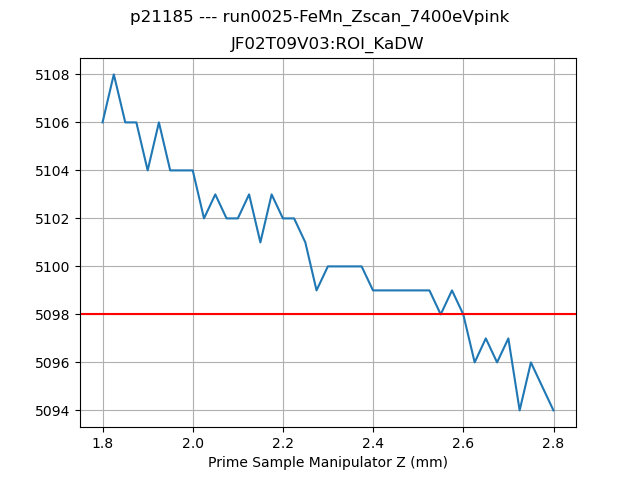

In [48]:
plt.figure()
plt.suptitle(titlestring)
plt.title(key)
plt.plot(Delay_fs, 5000+np.argmax(np.transpose(np.asarray(matrix_on_rebin) + np.asarray(matrix_off_rebin)), axis=0))
plt.axhline(y = 5098, color = 'r', linestyle = '-')
plt.xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
plt.grid()
plt.show()

In [9]:
def rebin2D(arr, axis, bin_):
    arr = np.array(arr)
    arr_new=[]
    if axis == 1:
        arr=arr.T
    for index in range(len(arr)):
        cut=arr[index]
        new=bin_sum(cut,bin_)
        arr_new.append(new)
    arr_new=np.array(arr_new)
    if axis == 1:
        arr_new=arr_new.T
    return arr_new

In [10]:
def plot_tool_2D(matrix_ON, matrix_OFF, axis, x_axis, bin_):
    
    matrix_on_rebin  = rebin2D(matrix_ON, axis, bin_)
    matrix_off_rebin = rebin2D(matrix_OFF, axis, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    
    return x_axis_rebin, matrix_on_rebin, matrix_off_rebin#, low_err, high_err

In [11]:
def plot_tool_static_2D(matrix, axis, x_axis, bin_):
    
    matrix_rebin  = rebin2D(matrix, axis, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    
    return x_axis_rebin, matrix_rebin